In [1]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score

from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, SAGEConv, NNConv
import matplotlib.pyplot as plt

In [2]:
%run dataset_nc.ipynb

DATASET LOADED
Data(x=[42, 1], edge_index=[2, 40], edge_attr=[40, 1], y=[42, 35])


Processing...
Done!


In [113]:
torch.manual_seed(42)
dataset = dataset_nc.shuffle()

train_dataset = dataset[:int(len(dataset) * 0.65)]
test_dataset = dataset[int(len(dataset) * 0.35):]

print(f'Number of graphs total: {len(dataset)}')
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(dataset[0])

Number of graphs total: 54
Number of training graphs: 35
Number of test graphs: 36
Data(x=[48, 1], edge_index=[2, 51], edge_attr=[51, 1], y=[48, 35])


In [118]:
from torch_geometric.loader import DataLoader

NUM_GRAPHS_PER_BATCH = 8
NUM_HIDDEN_CHANNELS = 64

train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

In [199]:
class GATGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(train_dataset.num_features, NUM_HIDDEN_CHANNELS, heads=4, edge_dim=1)
        self.lin1 = torch.nn.Linear(train_dataset.num_features, 4 * NUM_HIDDEN_CHANNELS)
        
        self.conv2 = GATConv(4 * NUM_HIDDEN_CHANNELS, NUM_HIDDEN_CHANNELS, heads=4, edge_dim=1)
        self.lin2 = torch.nn.Linear(4 * NUM_HIDDEN_CHANNELS, 4 * NUM_HIDDEN_CHANNELS)
        
        self.conv3 = GATConv(4 * NUM_HIDDEN_CHANNELS, train_dataset.num_classes, heads=6, concat=False, edge_dim=1)
        self.lin3 = torch.nn.Linear(4 * NUM_HIDDEN_CHANNELS, train_dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
        x = self.conv3(x, edge_index) + self.lin3(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATGNN().to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

loss_values = []
acc_values = []
for epoch in range(1, 501):
    loss = train()
    #val_f1 = test(val_loader)
    test_f1 = test(test_loader)
    loss_values.append(loss)
    acc_values.append(test_f1)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, 'f'Test: {test_f1:.4f}')


GATGNN(
  (conv1): GATConv(1, 128, heads=4)
  (lin1): Linear(in_features=1, out_features=512, bias=True)
  (conv2): GATConv(512, 128, heads=4)
  (lin2): Linear(in_features=512, out_features=512, bias=True)
  (conv3): GATConv(512, 35, heads=6)
  (lin3): Linear(in_features=512, out_features=35, bias=True)
)
Number of parameters:  657806
Epoch: 001, Loss: 2.2947, Test: 0.0720
Epoch: 002, Loss: 2.3545, Test: 0.1063
Epoch: 003, Loss: 1.3900, Test: 0.1994
Epoch: 004, Loss: 0.6934, Test: 0.3146
Epoch: 005, Loss: 0.2932, Test: 0.1966
Epoch: 006, Loss: 0.1901, Test: 0.2656
Epoch: 007, Loss: 0.1297, Test: 0.2946
Epoch: 008, Loss: 0.1037, Test: 0.2818
Epoch: 009, Loss: 0.0901, Test: 0.2796
Epoch: 010, Loss: 0.0808, Test: 0.2127
Epoch: 011, Loss: 0.0790, Test: 0.3567
Epoch: 012, Loss: 0.0714, Test: 0.2957
Epoch: 013, Loss: 0.0747, Test: 0.4411
Epoch: 014, Loss: 0.0777, Test: 0.2803
Epoch: 015, Loss: 0.0733, Test: 0.4209
Epoch: 016, Loss: 0.0760, Test: 0.3838
Epoch: 017, Loss: 0.0696, Test: 0.3726


Epoch: 203, Loss: 0.0377, Test: 0.7262
Epoch: 204, Loss: 0.0400, Test: 0.7428
Epoch: 205, Loss: 0.0368, Test: 0.8349
Epoch: 206, Loss: 0.0252, Test: 0.7814
Epoch: 207, Loss: 0.0260, Test: 0.8031
Epoch: 208, Loss: 0.0245, Test: 0.8663
Epoch: 209, Loss: 0.0207, Test: 0.8038
Epoch: 210, Loss: 0.0200, Test: 0.8667
Epoch: 211, Loss: 0.0172, Test: 0.8617
Epoch: 212, Loss: 0.0179, Test: 0.8505
Epoch: 213, Loss: 0.0178, Test: 0.8789
Epoch: 214, Loss: 0.0273, Test: 0.7956
Epoch: 215, Loss: 0.0311, Test: 0.8460
Epoch: 216, Loss: 0.0285, Test: 0.7814
Epoch: 217, Loss: 0.0232, Test: 0.8654
Epoch: 218, Loss: 0.0180, Test: 0.7997
Epoch: 219, Loss: 0.0200, Test: 0.8625
Epoch: 220, Loss: 0.0190, Test: 0.8716
Epoch: 221, Loss: 0.0229, Test: 0.8294
Epoch: 222, Loss: 0.0295, Test: 0.8645
Epoch: 223, Loss: 0.0283, Test: 0.8448
Epoch: 224, Loss: 0.0237, Test: 0.8501
Epoch: 225, Loss: 0.0243, Test: 0.7206
Epoch: 226, Loss: 0.0274, Test: 0.8609
Epoch: 227, Loss: 0.0261, Test: 0.7679
Epoch: 228, Loss: 0.0261,

Epoch: 414, Loss: 0.0154, Test: 0.8520
Epoch: 415, Loss: 0.0232, Test: 0.8385
Epoch: 416, Loss: 0.0226, Test: 0.7894
Epoch: 417, Loss: 0.0261, Test: 0.7557
Epoch: 418, Loss: 0.0238, Test: 0.8575
Epoch: 419, Loss: 0.0228, Test: 0.8325
Epoch: 420, Loss: 0.0250, Test: 0.8682
Epoch: 421, Loss: 0.0212, Test: 0.8199
Epoch: 422, Loss: 0.0244, Test: 0.8484
Epoch: 423, Loss: 0.0189, Test: 0.7718
Epoch: 424, Loss: 0.0235, Test: 0.8636
Epoch: 425, Loss: 0.0238, Test: 0.8060
Epoch: 426, Loss: 0.0188, Test: 0.8549
Epoch: 427, Loss: 0.0224, Test: 0.8629
Epoch: 428, Loss: 0.0198, Test: 0.8800
Epoch: 429, Loss: 0.0199, Test: 0.8519
Epoch: 430, Loss: 0.0162, Test: 0.8351
Epoch: 431, Loss: 0.0224, Test: 0.7854
Epoch: 432, Loss: 0.0441, Test: 0.8538
Epoch: 433, Loss: 0.0307, Test: 0.7273
Epoch: 434, Loss: 0.0373, Test: 0.8874
Epoch: 435, Loss: 0.0300, Test: 0.8619
Epoch: 436, Loss: 0.0260, Test: 0.8321
Epoch: 437, Loss: 0.0220, Test: 0.8659
Epoch: 438, Loss: 0.0290, Test: 0.8647
Epoch: 439, Loss: 0.0320,

GATGNN2(
  (conv1): GATConv(1, 64, heads=4)
  (lin1): Linear(in_features=1, out_features=256, bias=True)
  (conv2): GATConv(256, 64, heads=4)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (conv3): GATConv(256, 35, heads=6)
  (lin3): Linear(in_features=256, out_features=35, bias=True)
)
Number of parameters:  198286
Epoch: 001, Loss: 0.9328, Train: 0.0775, Test: 0.0888
Epoch: 002, Loss: 0.4500, Train: 0.0596, Test: 0.0652
Epoch: 003, Loss: 0.3825, Train: 0.3837, Test: 0.4312
Epoch: 004, Loss: 0.3436, Train: 0.2475, Test: 0.1875
Epoch: 005, Loss: 0.2550, Train: 0.2644, Test: 0.2554
Epoch: 006, Loss: 0.2222, Train: 0.3350, Test: 0.3379
Epoch: 007, Loss: 0.2028, Train: 0.3787, Test: 0.3487
Epoch: 008, Loss: 0.1380, Train: 0.3002, Test: 0.2645
Epoch: 009, Loss: 0.1304, Train: 0.4791, Test: 0.5027
Epoch: 010, Loss: 0.0953, Train: 0.4105, Test: 0.3397
Epoch: 011, Loss: 0.0929, Train: 0.5308, Test: 0.5136
Epoch: 012, Loss: 0.0789, Train: 0.5567, Test: 0.5670
Epoch: 013, Loss

Epoch: 147, Loss: 0.0244, Train: 0.8529, Test: 0.7726
Epoch: 148, Loss: 0.0267, Train: 0.8509, Test: 0.7808
Epoch: 149, Loss: 0.0271, Train: 0.8330, Test: 0.7754
Epoch: 150, Loss: 0.0305, Train: 0.8320, Test: 0.7690
Epoch: 151, Loss: 0.0279, Train: 0.8300, Test: 0.8261
Epoch: 152, Loss: 0.0303, Train: 0.8449, Test: 0.8324
Epoch: 153, Loss: 0.0277, Train: 0.8221, Test: 0.7545
Epoch: 154, Loss: 0.0264, Train: 0.9046, Test: 0.8904
Epoch: 155, Loss: 0.0226, Train: 0.8678, Test: 0.8379
Epoch: 156, Loss: 0.0220, Train: 0.9254, Test: 0.8958
Epoch: 157, Loss: 0.0216, Train: 0.8300, Test: 0.8161
Epoch: 158, Loss: 0.0285, Train: 0.8231, Test: 0.8089
Epoch: 159, Loss: 0.0280, Train: 0.8032, Test: 0.7364
Epoch: 160, Loss: 0.0381, Train: 0.8330, Test: 0.7690
Epoch: 161, Loss: 0.0356, Train: 0.8360, Test: 0.8134
Epoch: 162, Loss: 0.0377, Train: 0.7773, Test: 0.6866
Epoch: 163, Loss: 0.0341, Train: 0.8111, Test: 0.7545
Epoch: 164, Loss: 0.0282, Train: 0.8897, Test: 0.8822
Epoch: 165, Loss: 0.0296, Tr

Epoch: 299, Loss: 0.0130, Train: 0.8797, Test: 0.8514
Epoch: 300, Loss: 0.0158, Train: 0.8857, Test: 0.8524
Epoch: 301, Loss: 0.0164, Train: 0.9026, Test: 0.8732
Epoch: 302, Loss: 0.0142, Train: 0.8976, Test: 0.8478
Epoch: 303, Loss: 0.0150, Train: 0.8807, Test: 0.8505
Epoch: 304, Loss: 0.0161, Train: 0.8926, Test: 0.8659
Epoch: 305, Loss: 0.0158, Train: 0.9016, Test: 0.8514
Epoch: 306, Loss: 0.0159, Train: 0.9016, Test: 0.8705
Epoch: 307, Loss: 0.0181, Train: 0.9384, Test: 0.9022
Epoch: 308, Loss: 0.0162, Train: 0.8837, Test: 0.7908
Epoch: 309, Loss: 0.0201, Train: 0.8996, Test: 0.8705
Epoch: 310, Loss: 0.0169, Train: 0.9046, Test: 0.8732
Epoch: 311, Loss: 0.0157, Train: 0.9095, Test: 0.8668
Epoch: 312, Loss: 0.0150, Train: 0.9016, Test: 0.8505
Epoch: 313, Loss: 0.0131, Train: 0.9016, Test: 0.8696
Epoch: 314, Loss: 0.0150, Train: 0.8907, Test: 0.8687
Epoch: 315, Loss: 0.0157, Train: 0.9006, Test: 0.8723
Epoch: 316, Loss: 0.0154, Train: 0.8797, Test: 0.8542
Epoch: 317, Loss: 0.0161, Tr

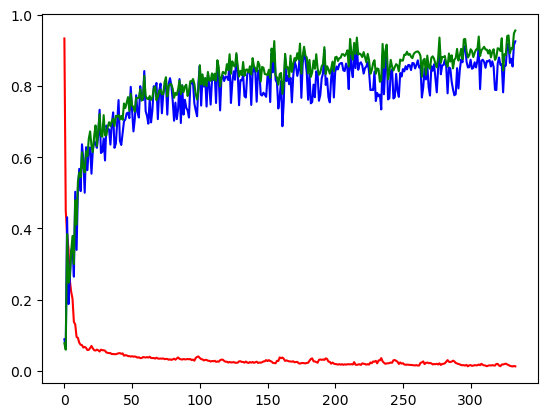

Max Accuracy: 0.9248


In [115]:
max_acc = 0
class GATGNN2(torch.nn.Module): # uses edge_attr
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(train_dataset.num_features, NUM_HIDDEN_CHANNELS, heads=4, edge_dim=1)
        self.lin1 = torch.nn.Linear(train_dataset.num_features, 4 * NUM_HIDDEN_CHANNELS)
        
        self.conv2 = GATConv(4 * NUM_HIDDEN_CHANNELS, NUM_HIDDEN_CHANNELS, heads=4, edge_dim=1)
        self.lin2 = torch.nn.Linear(4 * NUM_HIDDEN_CHANNELS, 4 * NUM_HIDDEN_CHANNELS)
        
        self.conv3 = GATConv(4 * NUM_HIDDEN_CHANNELS, train_dataset.num_classes, heads=6, concat=False, edge_dim=1)
        self.lin3 = torch.nn.Linear(4 * NUM_HIDDEN_CHANNELS, train_dataset.num_classes)

        
    def forward(self, x, edge_index, edge_attr):
        x = F.elu(self.conv1(x, edge_index, edge_attr) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index, edge_attr) + self.lin2(x))
        x = self.conv3(x, edge_index, edge_attr) + self.lin3(x)
        return x



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATGNN2().to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index, data.edge_attr), data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


def flatten(l):
    return [item for sublist in l for item in sublist]


@torch.no_grad()
def test2(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append([int(y.argmax()) for y in data.y])
        out = model(data.x.to(device), data.edge_index.to(device), edge_attr=data.edge_attr.to(device))
        preds.append([int(pred.argmax()) for pred in out])

    preds = flatten(preds)
    ys = flatten(ys)
    correct = 0
    
    for y, pred in zip(ys, preds):
        if(y == pred):
            correct += 1
    
    return correct / len(ys)


@torch.no_grad()
def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out = model(data.x.to(device), data.edge_index.to(device), edge_attr=data.edge_attr.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

loss_values = []
train_acc_values = []
acc_values = []
for epoch in range(1, 501):
    loss = train()
    train_acc = test2(train_loader)
    test_acc = test2(test_loader)
    if(test_acc > max_acc):
        max_acc = test_acc
    
    loss_values.append(loss)
    acc_values.append(test_acc)
    train_acc_values.append(train_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, 'f'Train: {train_acc:.4f}, 'f'Test: {test_acc:.4f}')
    
    if(test_acc >= 0.92):
        break

plt.plot(loss_values, 'r', acc_values, 'b', train_acc_values, 'g')
plt.show()
print(f'Max Accuracy: {max_acc:.4f}')

In [116]:
torch.save(model, 'models/model_nc.pth')

In [119]:
loaded_model = torch.load('models/model_nc.pth')
loaded_model.eval()
test_acc = test2(test_loader)
print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.9248


In [93]:
def flatten(l):
    return [item for sublist in l for item in sublist]

@torch.no_grad()
def test2(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append([int(y.argmax()) for y in data.y])
        out = model(data.x.to(device), data.edge_index.to(device), edge_attr=data.edge_attr.to(device))
        preds.append([int(pred.argmax()) for pred in out])

    preds = flatten(preds)
    ys = flatten(ys)
    print(len(preds))
    print(len(ys))
    correct = 0
    
    for y, pred in zip(ys, preds):
        if(y == pred):
            correct += 1
    
    print(correct / len(ys))
    

test_f1 = test2(test_loader)

700
700
0.8228571428571428


SAGEGNN(
  (conv1): SAGEConv(1, 64)
  (conv2): SAGEConv(64, 256)
  (conv3): SAGEConv(256, 512)
  (lin1): Linear(in_features=512, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=35, bias=True)
)
Number of parameters:  445923
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 001, Loss: 0.4150, Test: 0.0000
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 002, Loss: 0.1913, Test: 0.0028
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 003, Loss: 0.1659, Test: 0.1474
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 004, Loss: 0.1468, Test: 0.0056
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 005, Loss: 0.1467, Test: 0.0000
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 006, Loss: 0.1410, Test: 0.0887
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([2

torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 080, Loss: 0.0448, Test: 0.5943
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 081, Loss: 0.0441, Test: 0.5073
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 082, Loss: 0.0433, Test: 0.5548
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 083, Loss: 0.0422, Test: 0.5163
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 084, Loss: 0.0406, Test: 0.5822
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 085, Loss: 0.0406, Test: 0.6576
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 086, Loss: 0.0390, Test: 0.6053
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 087, Loss: 0.0393, Test: 0.6157
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 088, Loss: 0.0386, Test: 0.5895
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size(

torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 161, Loss: 0.0269, Test: 0.7011
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 162, Loss: 0.0258, Test: 0.7539
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 163, Loss: 0.0255, Test: 0.7427
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 164, Loss: 0.0247, Test: 0.7648
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 165, Loss: 0.0255, Test: 0.7096
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 166, Loss: 0.0247, Test: 0.7500
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 167, Loss: 0.0258, Test: 0.7600
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 168, Loss: 0.0254, Test: 0.7270
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 169, Loss: 0.0254, Test: 0.7701
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size(

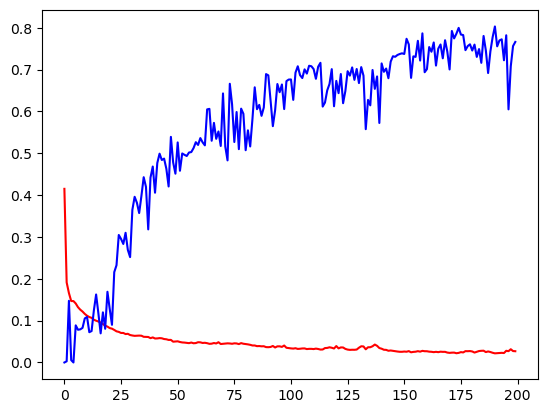

In [221]:
class SAGEGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(42)
        self.conv1 = SAGEConv(train_dataset.num_node_features, NUM_HIDDEN_CHANNELS)
        self.conv2 = SAGEConv(NUM_HIDDEN_CHANNELS, 4 * NUM_HIDDEN_CHANNELS)
        self.conv3 = SAGEConv(4 * NUM_HIDDEN_CHANNELS, 8 * NUM_HIDDEN_CHANNELS)
        self.lin1 = torch.nn.Linear(8 * NUM_HIDDEN_CHANNELS, 4 * NUM_HIDDEN_CHANNELS)
        self.lin2 = torch.nn.Linear(4 * NUM_HIDDEN_CHANNELS, NUM_HIDDEN_CHANNELS)
        self.lin3 = torch.nn.Linear(NUM_HIDDEN_CHANNELS, train_dataset.num_classes)
        

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
#         x = self.conv3(x, edge_index)
#         x = x.relu()
#         x = self.lin1(x)
#         x = x.relu()
        x = self.lin2(x)
        x = x.relu()
        x = self.lin3(x)

        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGEGNN().to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
# loss_op = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out = model(data.x.to(device), data.edge_index.to(device))
        print(out.shape)
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

loss_values = []
acc_values = []
for epoch in range(1, 201):
    loss = train()
    test_f1 = test(test_loader)
    loss_values.append(loss)
    acc_values.append(test_f1)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, 'f'Test: {test_f1:.4f}')

plt.plot(loss_values, 'r', acc_values, 'b',)
plt.show()